### Estimating the Brock & Hommes (1998) model

This is a model that needs no introduction, and while the reduced form that is typically used and estimated in the literature is a fully-fledged agent-based model, it forms a really good test-bed for ABM estimation. This is because:
- It is popular in the financial ABM literautre (always a good reason!)
- It is actually challenging to estimate despite its simple implementation. 

An important feature of the model is the rich dynamics that it is able to generate. From the point of view of estimation, the problem is one of identification, more specifically observational equivalence. As will be discussed in several locations below, this tends to generate multiple equilibria and flat objective functions (likelihood or moment-based distance).

**Note:** This notebook takes a *looong* time to run, especially the SMM portions, so be careful re-running it. It's one of these jobs that you put in the oven before leaving the office and come back in the morning to see if it's cooked. This (unfortunate) aspect is part of what I want to show with this workshop.

As always, we start with some imports and function declarations

In [1]:
import time
import numpy as np
import pandas as pd

from scipy.stats import norm, skew, kurtosis
from numpy.random import default_rng
from matplotlib import pyplot as plt
from scipy.optimize import minimize
from workshopFunctions import brockHommes, smm, npsmle, autocorr, formatTableText
from statsmodels.iolib.table import SimpleTable

#%% --------------------------------------------------------------------------
# Declare any extra functions

def hill(y,alpha):
    """
    Calculate the hill index of the data

    Parameters
    ----------
    y : numpy 1D array of floats
        input data.
    alpha : float
        Quantile for the size of the right hand side tail.

    Returns
    -------
    iota : float64
        hill index of the input data.

    """
    ysort = np.sort(y)                                # sort the returns
    n = len(y)
    k = int(np.floor(n*(1-alpha)))
    iota = 1/(np.mean(np.log(ysort[k:]) - np.log(ysort[k])))   # get the index
    return iota

def genMoments(data):
    """
    Generate the moments

    Parameters
    ----------
    data : numpy 1D array of floats
        Input data..

    Returns
    -------
    moments : numpy 1D array of floats
        Vector containing the moments of interest

    """
    data = data.flatten() # in case the data isn't already flat

    # Append moments below. Note the extra moments compared to the AR(2) case
    acf = autocorr(data)
    absData = abs(data)
    absAcf = autocorr(absData)
    
    moments = np.array(np.mean(absData))
    moments = np.append(moments,skew(data))
    moments = np.append(moments,kurtosis(data))

    moments = np.append(moments,acf[1])
    moments = np.append(moments,absAcf[1])
    moments = np.append(moments,(absAcf[4]+absAcf[5]+absAcf[6])/3)
    moments = np.append(moments,(absAcf[9]+absAcf[10]+absAcf[11])/3)
    moments = np.append(moments,(absAcf[24]+absAcf[25]+absAcf[26])/3)
    moments = np.append(moments,(absAcf[49]+absAcf[50]+absAcf[51])/3)
    moments = np.append(moments,(absAcf[99]+absAcf[100]+absAcf[101])/3)
    
    moments = np.append(moments,hill(absData,0.05))
    
    return moments
    

Comparing the moment-generating function with the one we used for the AR(2) example, one can see that the set of moments has increased. As explained previously, this should not be a surprise, SMM requires . 

In this case of the Brock & Hommes estimation, we broadly follow Kukacka & Barunick (2017).

<br>

#### Parameter recovery exercise
<br>

First, see if we can use SMM and NPSMLE to recover parameters of known DGP. Let's generate some fake data


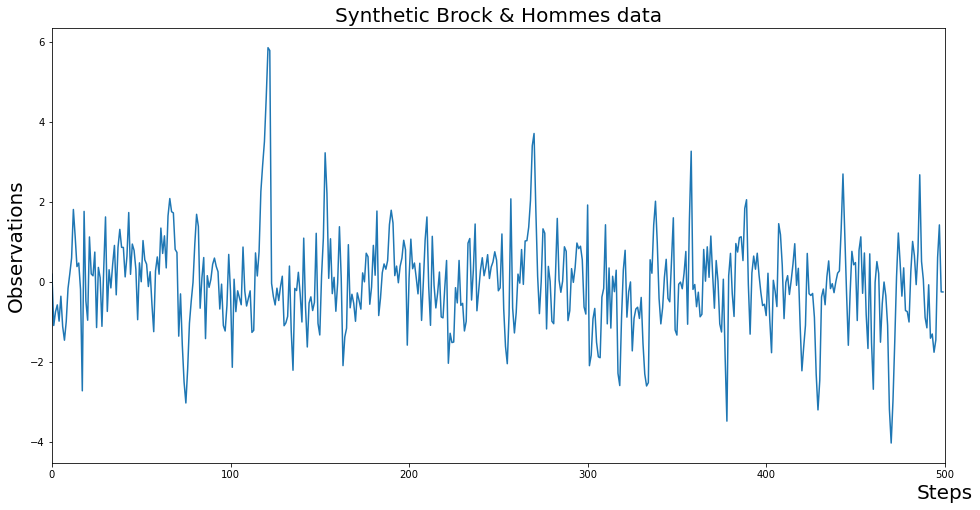

In [2]:
# Simulate sythetic data
beta = 6
sigma = 1
b = 0
g = 1.2
betaVec = np.asarray([beta,sigma,b,g])
paramNames = ['Beta', 'Sigma','b_2','g_2']

seed = 400
T = 500
N = 1000
tolerance = 1e-3 # Be generous. These are MC methods!

BHsim = brockHommes(seed = 3, r = 0.1)
BHsimData = BHsim.simulate(T+3,betaVec)
y = BHsimData[3:T+3]

# Plot the data
fig = plt.figure(figsize=(16,8))
fig.set_facecolor('white')
ax = plt.axes()
ax.plot(np.arange(T), y)
ax.set_xlim(0,T)
ax.set_xlabel(r'Steps', fontdict = {'fontsize': 20},position=(1, 0))
ax.set_ylabel(r'Observations', fontdict = {'fontsize': 20},position=(0, 0.5))
ax.set_title('Synthetic Brock & Hommes data', fontdict = {'fontsize': 20});

Let's attempt to recover the parameters of the test DGP using NPSMLE.

In [3]:
print(' Running NPSMLE on synthetic Brock & Hommes data')
t_start = time.time()

init = np.asarray([2,2,0,0])
epsRng = default_rng(seed = seed)
epsilon = norm.ppf(epsRng.random((N,1)))

BHnpsmle = npsmle(y,paramNames)
negLogLik = lambda a : -sum(BHnpsmle.logLike(BHsim.step,3,a,epsilon)/T)
smleEstimation = minimize(negLogLik, 
                          init,
                          method='BFGS', 
                          callback=BHnpsmle.callback,   
                          options={'disp':True,
                                   'gtol':tolerance})
timeNpsmle = time.time() - t_start
print('Total time: {:10.4f} secs.'.format(timeNpsmle))
for name, value in zip(paramNames, smleEstimation.x):
    print('{:s} estimate: {:10.4f}'.format(name, value))

 Running NPSMLE on synthetic Brock & Hommes data
 iteration      time         Beta         Sigma         b_2          g_2      
──────────────────────────────────────────────────────────────────────────────
     1        3.6285e+00   2.0000e+00   2.8749e+00  -9.9582e-03   5.0450e-01  
     2        5.7362e+00   2.0431e+00   2.6704e+00  -2.1341e-02   1.0776e+00  
     3        3.7272e+00   2.1005e+00   2.6702e+00   3.2778e-02   1.0822e+00  
     4        3.7854e+00   2.5845e+00   2.6785e+00   2.8567e-02   1.0840e+00  
     5        1.7634e+00   3.0689e+00   2.7422e+00   2.1302e-02   1.0893e+00  
     6        1.7820e+00   3.8532e+00   2.9066e+00   2.3225e-02   1.1012e+00  
     7        1.7668e+00   5.0193e+00   3.1973e+00   2.2787e-02   1.1196e+00  
     8        1.7699e+00   5.7365e+00   3.3742e+00   2.1796e-02   1.1270e+00  
     9        1.7713e+00   6.1743e+00   3.4686e+00   2.0782e-02   1.1319e+00  
    10        1.7600e+00   6.3608e+00   3.4955e+00   2.0333e-02   1.1322e+00  
   

NPSMLE is not too bad in terms of time (~90 seconds), but clearly some of the estimates are a bit off compared to the known true values. Let's now see if SMM does better, and then discuss the reason for this once we have all the estimates.

In [4]:
print('{:s}\n Running SMM on synthetic Brock & Hommes, W = bootstrap\n'.format(
    u'\u2500' * 72))
t_start = time.time()
BHsmm = smm(y,genMoments, paramNames, bootstrap = True) # Bootstrapped W

smmObjective = lambda a : BHsmm.dist(BHsim.simulate,a,N=500)
smmmEstimation = minimize(smmObjective, 
                          init,
                          method='BFGS', 
                          callback = BHsmm.callback,     
                          tol = 1e-2,     # add to avoid slow convergence
                          options={'disp':True,
                                    'gtol':tolerance})

timeSmm = time.time() - t_start
print('Total time: {:10.4f} secs.'.format(timeSmm))

# Show tables to compare performance
# Gather parameter values 
parameterValues = np.concatenate(
                            (betaVec[None,:],
                             smleEstimation.x[None,:],
                             smmmEstimation.x[None,:]),
                                  axis=0)
# Gather compute times 
times = np.asarray([0,timeNpsmle,timeSmm])

# Print table
tableValues = np.concatenate((parameterValues,times[:,None]),axis = 1)
table = SimpleTable(
        formatTableText(tableValues,'{:8.3f}'),
        stubs=['True','NPSMLE', 'SMM btstrp W'],
        headers=paramNames + ['Time'],
        title='Estimation performance, parameter recovery',
    )

print(table)
print('\n')

────────────────────────────────────────────────────────────────────────
 Running SMM on synthetic Brock & Hommes, W = bootstrap

 iteration      time         Beta         Sigma         b_2          g_2      
──────────────────────────────────────────────────────────────────────────────
     1        9.3807e+01   2.0000e+00   1.2002e+00   2.4869e-04   6.1679e-01  
     2        1.4024e+02   1.9941e+00   1.0002e+00   4.4438e-02   4.0333e-01  
     3        4.7131e+01   1.9695e+00   9.4497e-01   5.7302e-01   3.5903e-01  
     4        1.4164e+02   2.0214e+00   9.3709e-01   6.4515e-01   3.5051e-01  
     5        4.6865e+01   2.3924e+00   9.2498e-01   6.2481e-01   3.5456e-01  
     6        4.7115e+01   3.0762e+00   8.9843e-01   5.7173e-01   3.6446e-01  
     7        4.6950e+01   5.3569e+00   8.5399e-01   4.7222e-01   4.0486e-01  
     8        4.6904e+01   7.7230e+00   8.3297e-01   4.2166e-01   4.5271e-01  
     9        4.7772e+01   1.1956e+01   8.1251e-01   3.5683e-01   5.4277e-01  
 

The first observation we can make is that the SMM estimation is clearly very time-consuming: this one took an hour! Note that this is despite the fact that the number of MC iterations was reduced from $N=1000$ in the simple AR(2) example to $N=500$ here in an attempt to reduce computation costs. 

This increase in time is due to:
- The fact that simulating the Brock & Hommes model takes longer than the AR(2) process.
- There are now 4 parameters to estimate instead of 2, so there is an element of 'curse of dimensionality' when BFGS estimates the gradient of the objective function. Remember that the gradient is estimated using the finite differences method, so more parameters means more calls to the Brock & Hommes simulation.

With the computational cost out of the way, let's look at the estimate themselves:
- Both methods produce inflated estimates on $\Beta$. This is not surprising, the intensity of choice is notoriously difficult to estimate correctly.
- Related to this is the high $\sigma$ estimate produced by the NPSMLE (The SMM one is actually not bad!). This is symptomatic of observational equivalence: Essentially, NPSMLE thinks that the DGP has less switching and more noise, while SMM thinks there is much more switching and a lot less noise.
- NPSMLE does a decent job of recovering $b_2$ and $g_2$, SMM less so as it overestimates $b_2$ by a bit, even if the value effectively remains low.

Finally, it is important to comment on the iterations themselves. For both methods the steps taken tend to be small, and sometimes display 'zig-zag' behaviour, where the parameter values oscillate up and down as the iteration proceeds. This is symptomatic of the optimiser meandering over the solution surface, which itself indicates that the surface is locally flat.

<br>

#### Empirical estimation on S&P 500
<br>

We now move on to estimating the Brock & Hommes model on some real data, namely the S&P 500 index. For comparability, we follow Kukacka and Barunik (2017) in how we process the data:
- The start and end dates are 23rd of February 1994 and 31st of December 2013 (~ 5000 observations)
- The fundamental price is obtained by running a 61-day window moving average (MA-61), centered on the day of interest. This estimator of the fundamental price has the benefit of generating by construction a stationary series for the deviations from fundamentals.


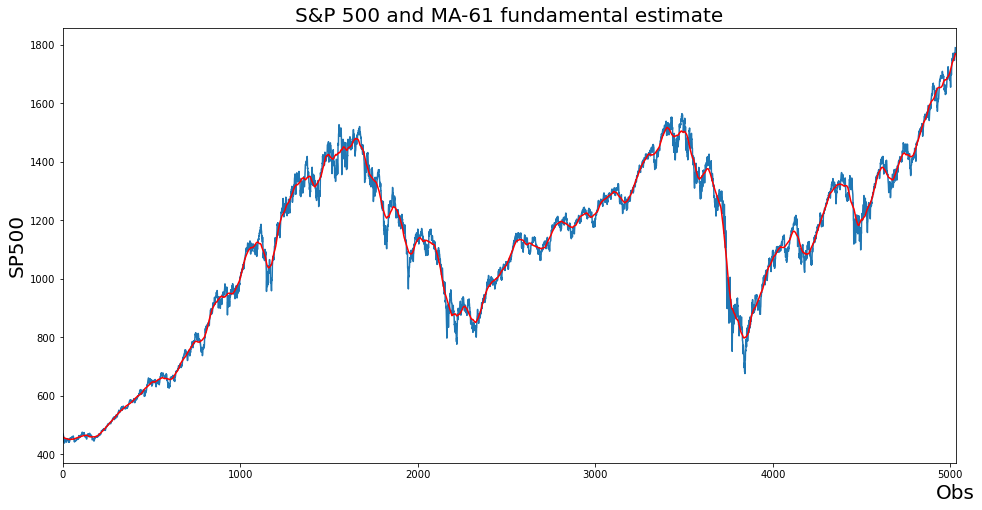

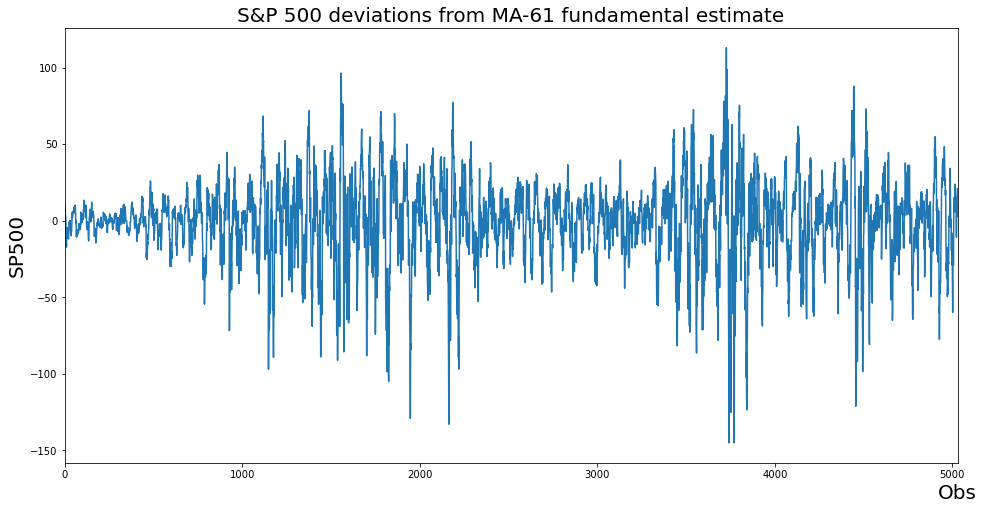

In [3]:
# We're going to load the S&P500 index data
dataPath = 'data/SP500.csv'
rawData = pd.read_csv(dataPath, index_col=[0])
rawData.index = pd.to_datetime(rawData.index)

# Let's pick the same start/end dates as Kukacka & Barunik (2017)
startDate = '1994-02-23'
endDate = '2013-12-31'
selection = (rawData.index >= startDate) & (rawData.index <= endDate)
data = rawData.loc[selection]
numRawObs = len(data)
y = np.flip(data.to_numpy()) # We need to 'numpify' the data and flip it

# Fundamental price - estimated with 61 day centered window
w = 30
numObs = numRawObs-2*w-1
yFun = np.zeros([numObs,1])
for i in range(w,numRawObs-w-1):
    yFun[i-w,:] = np.mean(y[i-w:i+w+1])
    
yDiff = y[w:numRawObs-w-1] - yFun
    
# Plot the S&P data and fundamental price, as well as deviations
fig = plt.figure(figsize=(16,8))
fig.set_facecolor('white')
ax = plt.axes()
ax.plot(np.arange(numObs), y[w:numRawObs-w-1])
ax.plot(np.arange(numObs), yFun, color = 'r')
ax.set_xlim(0,numObs)
ax.set_xlabel(r'Obs', fontdict = {'fontsize': 20},position=(1, 0))
ax.set_ylabel(r'SP500', fontdict = {'fontsize': 20},position=(0, 0.5))
ax.set_title('S&P 500 and MA-{:d} fundamental estimate'.format(2*w+1), 
             fontdict = {'fontsize': 20});

fig = plt.figure(figsize=(16,8))
fig.set_facecolor('white')
ax = plt.axes()
ax.plot(np.arange(numObs), yDiff)
ax.set_xlim(0,numObs)
ax.set_xlabel(r'Obs', fontdict = {'fontsize': 20},position=(1, 0))
ax.set_ylabel(r'SP500', fontdict = {'fontsize': 20},position=(0, 0.5))
ax.set_title('S&P 500 deviations from MA-{:d} fundamental estimate'.format(2*w+1), 
             fontdict = {'fontsize': 20});

The deviations from the fundamental price, plotted above, display the typical characteristics of financial data (e.g log returns). These are:
- Volatility clustering
- Asymmetries in shocks, with downswings being more pronounced than upward movements.

These justify the choice of moments used in the `genMoments` function declared at the start, as we need to make sure we capture those features. We therefore use the same moments as Franke (2009), which is a really good guide to using SMM on financial ABMs. In particular:
- We rely heavily on the autocorrelation of absolute returns at lags 1, 5, 10, 25, 50 and 100. To minimise the effect of sampling noise, lags above 1 are measured as the average of the $n-1$, $n$ and $n+1$ lags
- We include the hill index for the upper tail at 5%.
- In addition, we add the skewness and kurtosis of the series, the former to pick up the asymmetries mentioned above and the latter to help pick up tail events.

As previosuly, let's first run NPSMLE. It is important to note that the initial value of the parameters correspond to a *null model*, with no switching ($\beta=0$), all agents as fundamentalists ($b_2 = g_2 = 0$) and a standard deviation of noise equal to the standard deviation of the empirical data.

In [6]:
# Create a new Brock & Hommes simulation with the Kukacka & Barunik (2017)
# risk-free rate (around 2.5% annualised)
BHsimSP500 = brockHommes(seed = 3, r = 0.0001)

#Estimate with NPSMLE
print(' Running NPSMLE on S&P 500 data')
t_start = time.time()

init = np.asarray([0,np.std(yDiff),0,0]) # Initialise a null/ pure noise model
epsRng = default_rng(seed = seed)
epsilon = norm.ppf(epsRng.random((500,1)))
BHnpsmleSP500 = npsmle(yDiff,paramNames)
negLogLik = lambda a : -sum(BHnpsmleSP500.logLike(BHsimSP500.step,3,a,epsilon)/numObs)
smleEstimation = minimize(negLogLik, 
                          init,
                          method='BFGS', 
                          callback=BHnpsmleSP500.callback,   
                          options={'disp':True,
                                   'gtol':tolerance})
timeNpsmle = time.time() - t_start
print('Total time: {:10.4f} secs.'.format(timeNpsmle))
for name, value in zip(paramNames, smleEstimation.x):
    print('{:s} estimate: {:10.4f}'.format(name, value))

 Running NPSMLE on S&P 500 data
 iteration      time         Beta         Sigma         b_2          g_2      
──────────────────────────────────────────────────────────────────────────────
     1        2.6148e+01   0.0000e+00   2.6398e+01   3.3345e-03   1.0069e+00  
     2        3.9275e+01   1.0630e-03   2.6402e+01   3.5267e-03   1.0649e+00  
     3        7.8432e+01   3.6757e-05   2.4058e+01   3.1782e+00   1.4044e+00  
     4        1.3193e+01  -1.5549e-04   2.9966e+01   6.7573e+00   1.5721e+00  
     5        2.6208e+01   2.0416e-04   3.3650e+01   8.9741e+00   1.5005e+00  
     6        1.3057e+01   9.6138e-05   3.5752e+01   6.9069e+00   1.5340e+00  
     7        1.3846e+01  -1.1284e-04   3.8136e+01   5.1227e+00   1.7340e+00  
     8        1.3109e+01  -5.5276e-06   3.8944e+01   6.0063e+00   1.7088e+00  
     9        1.3199e+01  -3.4576e-06   3.9736e+01   6.1517e+00   1.7359e+00  
    10        1.3162e+01  -8.5219e-06   4.0557e+01   6.3117e+00   1.7528e+00  
    11        1.3189

OK, that took 10 times longer than the NPSMLE parameter recovery above, but it's still not too bad (~ 15 mins).  We will discuss the quality of the parameter estimates once we have the SMM estimates as well, but as a preliminary, we can see that NPSMLE has settled for a DGP with very little switching but a LOT of noise. In this context, interpreting the estimates for $b_2$ and $g_2$ is tricky, as they are probably not identified correctly.

Let's now turn to SMM and see what that approach shows. Again, as fair warning for those of you that want to re-run the notebook, this is again where you are likely to pay the time cost.

In [7]:
#Estimate with SMM
print('{:s}\n Running SMM on S&P 500 data, W = bootstrap\n'.format(
    u'\u2500' * 72))
t_start = time.time()
BHsmmSP500 = smm(yDiff,genMoments, paramNames, bootstrap = True) # Bootstrapped W

smmObjective = lambda a : BHsmm.dist(BHsimSP500.simulate,a,N=500)
smmmEstimation = minimize(smmObjective, 
                          init,
                          method='BFGS', 
                          callback = BHsmmSP500.callback,     
                          tol = 1e-2,     # add to avoid slow convergence
                          options={'disp':True,
                                    'gtol':tolerance})

timeSmm = time.time() - t_start
print('Total time: {:10.4f} secs.'.format(timeSmm))

────────────────────────────────────────────────────────────────────────
 Running SMM on S&P 500 data, W = bootstrap

 iteration      time         Beta         Sigma         b_2          g_2      
──────────────────────────────────────────────────────────────────────────────
     1        1.0321e+02   0.0000e+00   2.5359e+01  -1.9434e-03   3.1302e-01  
     2        1.8843e+02   5.6880e-04   2.5353e+01  -1.9542e-03   3.1458e-01  
     3        2.8264e+02   8.0731e-04   1.8520e+01  -1.4852e-02   2.5869e-01  
     4        9.4823e+01   9.7711e-04   1.4561e+01   1.4962e+01   3.0175e-01  
     5        4.7468e+01   1.1395e-03   1.2075e+01   1.3163e+01   3.2435e-01  
     6        4.7411e+01   5.1391e-03   7.2769e+00   5.2489e+00   4.3075e-01  
     7        9.4666e+01   9.4917e-03   2.1250e+00  -4.5522e-01   6.0019e-01  
     8        4.6862e+01   1.0061e-02   6.7193e-01  -1.4998e-01   6.2900e-01  
     9        4.6920e+01   1.0017e-02   7.9263e-01  -1.8674e-01   6.2683e-01  
    10       

As per the warning, this again took a long time (~80 minutes). before we compare the various estimates obtained, note again the small iteration steps which often display zig-zagging (by iteration 30 we seem to be done already...). OK, so what about the estimates? We display those below, in addition to the estimates obtained by Kukacka & Barunik (2017) using NPSMLE on the Brock & Hommes model.

In [12]:
# Gather parameter values 
parameterValues = np.concatenate(
                            (np.asarray([[0.015,0.653, 0.009, 1.567]]),
                             smleEstimation.x[None,:],
                             smmmEstimation.x[None,:]),
                                  axis=0)
# Gather compute times 
times = np.asarray([0,timeNpsmle,timeSmm])

# Print table
tableValues = np.concatenate((parameterValues,times[:,None]),axis = 1)
table = SimpleTable(
        formatTableText(tableValues,'{:8.3f}'),
        stubs=['K & B (2017)','NPSMLE', 'SMM btstrp W'],
        headers=paramNames + ['Time'],
        title='Estimation performance, SP500 estimation',
    )

print(table)
print('\n')


         Estimation performance, SP500 estimation        
               Beta    Sigma     b_2      g_2      Time  
---------------------------------------------------------
K & B (2017)    0.015    0.653    0.009    1.567    0.000
NPSMLE         -0.000   40.895    6.466    1.747  925.262
SMM btstrp W    0.009    0.803   -0.154    0.696 4844.613
---------------------------------------------------------




Comparing the estimates obtained here with those in Kukacka & Barunik (2017) shows us that the SMM estimation clearly outperforms NPSMLE. The SMM estimates are much more consistent with the estimates in the literature, even accounting for the fact the noise treatment here is much more simplistic than in Kukacka & Barunik (2017), who instead estimate a noise intensity in the model relative to the noise level in the data. They point out that correctly accounting for the noise process is key to good NPSMLE estimation, and it is clear this is the case here.

I also want to point out that the good performance of SMM here is down to luck, to some extent. In preparing this notebook I ran it over several architectures (so different floating point arithmetic implementations) that led to different - and widely different - solutions. One in particular saw extremely high SMM estimates for Beta (around 80 if I remember) and virtually no noise, suggesting that observational equivalence is a real issue here.

A final comment that is relevant to this workshop centers on the time consumption and open-ended nature of the iterative methods shown here: it is clear that flat likelihoods/SMM surfaces combined with and iterative methods create a problem, even with 'small' models. The question, for the second part of the workshop is what is going to happen if we scale up to a more 'realistic' ABM?